# Google Earth Engine
Jupyter Notebook by Alexandre Bevington (FLNRO, UNBC) github.com/bevingtona <br>
February 2, 2019

## 1 Prep Environment

### 1.0 Pip Install 

In [466]:
# https://developers.google.com/earth-engine/python_install_manual
# !pip install mpld3
#!pip install ipyleaflet

### 1.1 Import

In [467]:
# Import packages
from IPython.display import Image
from ipyleaflet import *
import ee
import numpy as np
import mpld3
import matplotlib as mp

import datetime
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.formula.api as smf
from matplotlib import dates
from pylab import *
from numpy import fft
from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import LinearRegression
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

### 1.2 Initialize

In [468]:
# Initialize
ee.Initialize()

# Matplotlib inline
%matplotlib inline

# Zoom
mpld3.enable_notebook()

## 2 Define Functions

### 2.0 Surface Reflectance

In [469]:
def SR(img):
    img = img.addBands(img.select(['blue', 'green', 'red', 'nir', 'swir1', 'swir2']).multiply(0.0001))
    img = img.addBands(img.select(['tir']).multiply(0.1));
    img = img.select(['blue_1', 'green_1', 'red_1', 'nir_1', 'swir1_1', 'swir2_1','tir_1'],['blue', 'green', 'red', 'nir', 'swir1', 'swir2','tir'])
    
    return img

### 2.1 NDVI

In [470]:
def NDVI(img):
    img = img.addBands(img.normalizedDifference(['nir', 'red']).rename('ndvi'))
    img = img.addBands(img.normalizedDifference(['green', 'nir']).rename('ndwi'))
    img = img.addBands(img.normalizedDifference(['green', 'swir1']).rename('mndwi'))
    img = img.addBands(img.normalizedDifference(['nir', 'swir1']).rename('ndmi'))
    img = img.addBands(img.normalizedDifference(['nir', 'swir2']).rename('nbr'))
    return img

### 2.2 Cloud Mask

In [471]:
def NDCI(img):
    img = img.addBands(img.select('tir').unitScale(240,270)); 
    img = img.addBands(img.normalizedDifference(['tir_1','swir2']))
    img = img.addBands(img.select('nd').gt(0.4).rename('clear'));
    img = img.addBands(img.select('nd').lte(0.4).rename('cloud'));
    mask = ee.Image(1).updateMask(img.select('cloud')).byte().reduceToVectors(
        {
            geometry: aoi, 
            crs: 'EPSG:3005', 
            scale: 300, 
            maxPixels: 1e13
        }
    )
      
    maskImg = ee.Image(1).subtract(ee.Image(1).clipToCollection(mask).unmask())
    
    return img.updateMask(maskImg)

## 3 Band Names

In [472]:
BANDS_MSS = ['B4', 'B4', 'B4', 'B5', 'B6', 'B6', 'B6', 'B6'];
BANDS_TM  = ['B1', 'B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B6'];
BANDS_ETM = ['B1', 'B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B6'];
BANDS_OLI = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10'];
BANDS_MSI = ['B1', 'B2', 'B3', 'B4', 'B8', 'B11','B12','B12'];
BANDS_AST = ['B01', 'B01', 'B01', 'B02', 'B3N', 'B04', 'B07', 'B13'];
NAMES_STD = ['blue2', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'tir',];

## 4 Area of Interest

In [482]:
nor = 56.862497
eas = -121.638316

m = Map(center=(nor, eas), zoom=12, basemap=basemaps.OpenTopoMap)
m

# wms = WMSLayer(
#     url="https://demo.boundlessgeo.com/geoserver/ows?",
#     layers="nasa:bluemarble"
# )

# m = Map(layers=(wms, ), center=(nor, eas), zoom=8)

# m

TWFwKGJhc2VtYXA9eyd1cmwnOiAnaHR0cHM6Ly97c30udGlsZS5vcGVudG9wb21hcC5vcmcve3p9L3t4fS97eX0ucG5nJywgJ2F0dHJpYnV0aW9uJzogJ01hcCBkYXRhOiAmY29weTsgPGEgaHLigKY=


In [494]:
# aoi_gee = {
#     'type':'Point', 'coordinates':[eas,nor]};

aoi_json = {
    "type": "Feature",
    "geometry": {"type": "Point",
        "coordinates": [eas, nor]}}
print aoi_json
offset_lon = 0.05
offset_lat = offset_lon/2

region = {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              eas-offset_lon,
              nor-offset_lat
            ],
            [
              eas+offset_lon,
              nor-offset_lat
            ],
            [
              eas+offset_lon,
              nor+offset_lat
            ],
            [
              eas-offset_lon,
              nor+offset_lat
            ],
            [
              eas-offset_lon,
              nor-offset_lat
            ]
          ]]
      }
    }
g = GeoJSON(data=region)
print region
m.add_layer(g)

{'geometry': {'type': 'Point', 'coordinates': [-121.638316, 56.862497]}, 'type': 'Feature'}
{'geometry': {'type': 'Polygon', 'coordinates': [[[-121.688316, 56.837497], [-121.588316, 56.837497], [-121.588316, 56.887496999999996], [-121.688316, 56.887496999999996], [-121.688316, 56.837497]]]}, 'type': 'Feature'}


## 5 Collections

In [476]:
# Merge Collections 
col = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR").select(BANDS_OLI, NAMES_STD)
col = col.merge(ee.ImageCollection("LANDSAT/LE07/C01/T1_SR").select(BANDS_ETM, NAMES_STD))
col = col.merge(ee.ImageCollection("LANDSAT/LT05/C01/T1_SR").select(BANDS_TM, NAMES_STD))
col = col.merge(ee.ImageCollection("LANDSAT/LT04/C01/T1_SR").select(BANDS_TM, NAMES_STD))

# Filter Collection
col = col.filterDate('1985-01-01','2020-01-01')
#col = col.filterMetadata("CLOUD_COVER", "less_than", 30)
#col = col.filter(ee.Filter.dayOfYear(100,250))
col = col.filterBounds(aoi)

print "There are ", col.size().getInfo(), " images in the collection." 

There are  1122  images in the collection.


## 6 First Image 

In [477]:
image = col.first()
image = SR(image)
image = NDVI(image)

print "The first image is:", image.get('LANDSAT_ID').getInfo()
print "The bands are:", image.bandNames().getInfo()
# print image.getInfo()

thumbnail = image.getThumbUrl({'bands':'swir1,nir,red', 'min':0,'max':0.6,'region':region})
Image(url=thumbnail)
# s = ipyleaflet.ImageOverlay(thumbnail)
# m.add_layer(s)

The first image is: LC08_L1TP_048020_20130328_20170310_01_T1
The bands are: [u'blue', u'green', u'red', u'nir', u'swir1', u'swir2', u'tir', u'ndvi', u'ndwi', u'mndwi', u'ndmi', u'nbr']


EEException: Failed to decode JSON.
Error: Type must be one of: [compoundvalue, date, bytes, point, dictionary, function, invocation, multipoint, linestring, linearring, multilinestring, polygon, multipolygon, geometrycollection, argumentref, valueref].
Object: "FeatureCollection".

### 6.2 Display first image

In [359]:
thumbnail = image.getThumbUrl({'bands': 'swir1,nir,red', 'min':0,'max':0.4,'size':'800'})
Image(url=thumbnail)

In [301]:
# Get a download URL for an image.
path = image.getDownloadUrl({
    'scale': 300,
    'crs': 'EPSG:4326'
})
print path

https://earthengine.googleapis.com/api/download?docid=74e3cbd87a972acafce0c756785222bb&token=9a75f8431ad509b98161e1911960ee2f


In [302]:
#Retrieve information over image collection
ts_values = col.getRegion(aoi,500).getInfo()

In [306]:
# Reshape Landsat 8
header = ts_values[0]
data = array(ts_values[1:])
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(float))]

# List of used image bands
band_list = ['nir',u'red']

iBands = [header.index(b) for b in band_list]

yData = data[0:,iBands].astype(np.float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)

# Reshape NDVI array into Pandas Dataframe
df = pd.DataFrame(data=ndvi*-1, index=time, columns=['ndvi'])
df = df.dropna()

df_monthly = df.resample('M').min()


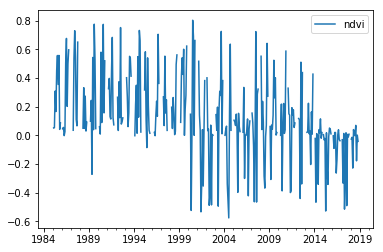

In [307]:
df_monthly.plot()

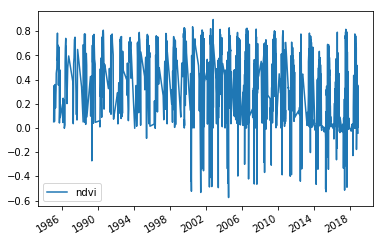

In [308]:
df.plot()

In [439]:
mean = col.mean()
print mean.bandNames().getInfo()
# print mean.getBounds().getInfo()
thumbnail = mean.getThumbUrl({'bands': 'swir1,nir,red', 'min':0,'max':0.4,'size':'800'})
Image(url=thumbnail)

[u'blue2', u'blue', u'green', u'red', u'nir', u'swir1', u'swir2', u'tir']


In [427]:
m = Map(center=(nor, eas), zoom=7)
print(thumbnail)
video = ImageOverlay(
    url=thumbnail,
    bounds=((nor-1, eas-1), (nor+1, eas+1))
)

m.add_layer(video);
m.add_layer(g)
m

https://earthengine.googleapis.com/api/thumb?thumbid=4982b3f5d4c97b03db1e2867f0b4ccaa&token=a0c4e0d21ad5ae3861b683a3d490a6d8


TWFwKGJhc2VtYXA9eyd1cmwnOiAnaHR0cHM6Ly97c30udGlsZS5vcGVuc3RyZWV0bWFwLm9yZy97en0ve3h9L3t5fS5wbmcnLCAnbWF4X3pvb20nOiAxOSwgJ2F0dHJpYnV0aW9uJzogJ01hcCDigKY=
